# Import Modules

This notebook is based on the pytorch tutorial from the official pytorch website: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.nn import functional as F

import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import os
import copy
import random
import time


plt.ion()   # interactive mode

# Connect to GDrive

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# create a symbolic link
!ln -s /content/gdrive/My\ Drive/ /mydrive

!ls /mydrive

# navigate to /mydrive/car-damage-project
%cd /mydrive/car-damage-project
!ls

/
Mounted at /content/gdrive
 Adriana.jpg	       'IACV Cards.gdoc'      output.txt	    VAMR.gdoc
 car-damage-project    'Introduction to ML'   pytorch-tutorial	    yolov4
'Colab Notebooks'      'My Drive'	     'USA 2019'
'FDS - Team 4.gsheet'   output_resnet.txt    'VAMR Complete.gdoc'
/content/gdrive/My Drive/car-damage-project
car-damage-detection-notebooks	kaggle_data    trainpaths.txt
gen_paths.py			testpaths.txt


# Set seed for reproducability

In [ ]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

data_dir = 'kaggle_data/'

# Load Images

In [ ]:
#data transformation
data_transforms = {
    'training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=(-20, 20)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['training', 'validation']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['training', 'validation']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation']}
print("Dataset size for training data: ", dataset_sizes['training'])
print("Dataset size for validation data: ", dataset_sizes['validation'])

class_names = image_datasets['training'].classes
print("Class names: ", class_names)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Dataset size for training data:  1840
Dataset size for validation data:  460
Class names:  ['00-damage', '01-whole']


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

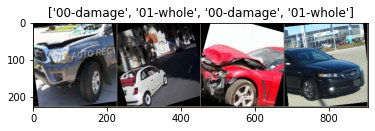

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['training']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the convnet

Instead of random initializaion, the model is initialized using a pretrained network, after which the training proceeds as usual but with a different dataset. Usually the head (or part of it) is also replaced in the network in case there is a different number of outputs. It is common in this method to set the learning rate to a smaller number. This is done because the network is already trained, and only minor changes are required to “finetune” it to a new dataset.

The pretrained resnet18 model is loaded and the final fully connected layer is reset.

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
training Loss: 0.5994 Acc: 0.7321
validation Loss: 0.2066 Acc: 0.9239

Epoch 1/24
----------
training Loss: 0.7013 Acc: 0.7364
validation Loss: 0.5330 Acc: 0.8000

Epoch 2/24
----------
training Loss: 0.6960 Acc: 0.7234
validation Loss: 0.3532 Acc: 0.8652

Epoch 3/24
----------
training Loss: 0.5706 Acc: 0.7565
validation Loss: 0.2392 Acc: 0.9174

Epoch 4/24
----------
training Loss: 0.5268 Acc: 0.7853
validation Loss: 0.2391 Acc: 0.9043

Epoch 5/24
----------
training Loss: 0.4801 Acc: 0.8076
validation Loss: 0.3222 Acc: 0.8674

Epoch 6/24
----------
training Loss: 0.5282 Acc: 0.7821
validation Loss: 0.1496 Acc: 0.9391

Epoch 7/24
----------
training Loss: 0.3867 Acc: 0.8359
validation Loss: 0.2065 Acc: 0.9283

Epoch 8/24
----------
training Loss: 0.3563 Acc: 0.8560
validation Loss: 0.2398 Acc: 0.9065

Epoch 9/24
----------
training Loss: 0.3513 Acc: 0.8473
validation Loss: 0.2120 Acc: 0.9261

Epoch 10/24
----------
training Loss: 0.3490 Acc: 0.8538
validation Lo

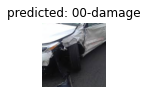

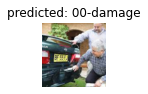

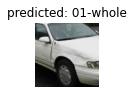

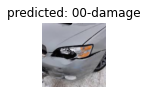

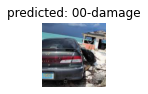

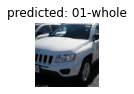

In [ ]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor

Here, you “freeze” the weights of all the parameters in the network except that of the final several layers (aka “the head”, usually fully connected layers). These last layers are replaced with new ones initialized with random weights and only these layers are trained.

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
training Loss: 0.6479 Acc: 0.7092
validation Loss: 1.0579 Acc: 0.6217

Epoch 1/24
----------
training Loss: 0.6670 Acc: 0.7424
validation Loss: 0.4864 Acc: 0.7848

Epoch 2/24
----------
training Loss: 0.6315 Acc: 0.7348
validation Loss: 0.2761 Acc: 0.8674

Epoch 3/24
----------
training Loss: 0.6386 Acc: 0.7451
validation Loss: 1.2415 Acc: 0.6087

Epoch 4/24
----------
training Loss: 0.5915 Acc: 0.7576
validation Loss: 0.3359 Acc: 0.8587

Epoch 5/24
----------
training Loss: 0.5942 Acc: 0.7641
validation Loss: 0.6849 Acc: 0.7478

Epoch 6/24
----------
training Loss: 0.6305 Acc: 0.7647
validation Loss: 0.3468 Acc: 0.8457

Epoch 7/24
----------
training Loss: 0.4713 Acc: 0.7940
validation Loss: 0.3452 Acc: 0.8478

Epoch 8/24
----------
training Loss: 0.4598 Acc: 0.8000
validation Loss: 0.3360 Acc: 0.8500

Epoch 9/24
----------
training Loss: 0.4739 Acc: 0.7897
validation Loss: 0.2802 Acc: 0.8674

Epoch 10/24
----------
training Loss: 0.4750 Acc: 0.7755
validation Lo

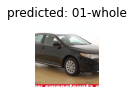

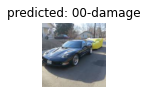

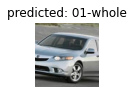

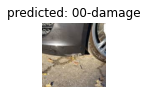

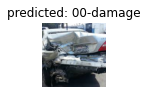

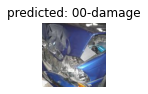

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()